In [23]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/andreanavarrete/workspace/columbia/courses/capstone/BlackLivesMatter/dsi-capstone-f19-group-1-51b3e5d95350.json'


In [24]:
import json
import matplotlib.pyplot as plt
import re
import numpy as np
import swifter

from google.cloud import bigquery

%load_ext google.cloud.bigquery
plt.style.use('fivethirtyeight')

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [25]:
keys = ['Pronoun', 'Ppron',
        'I', 'We', 'You', 'SheHe', 'They',
        'Anger', 'Sad',
        'Sexual', 
        'Negate',
        'Social', 'Family', 'Friend',
        'Percept', 
        'Swear',
        'Drives', 'Affiliation',
        'Achieve', 'Power', 'Reward', 
        'Risk', 'Death']

In [26]:
bigquery_client = bigquery.Client(project='dsi-capstone-f19-group-1')

In [27]:
%%bigquery tweets
WITH ids as (
SELECT id, day_of_tweet
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2 AND is_retweet = FALSE
)
SELECT
    id, day_of_tweet, cleaned_text_length, is_retweet,
    CASE  WHEN (Pronoun_length > 0)  then 1 else 0 end as pronoun_dummy,
    CASE  WHEN (Ppron_length > 0)  then 1 else 0 end as ppron_dummy,
    CASE  WHEN (I_length > 0)  then 1 else 0 end as i_dummy,
    CASE  WHEN (We_length > 0)  then 1 else 0 end as we_dummy,
    CASE  WHEN (You_length > 0)  then 1 else 0 end as you_dummy,
    CASE  WHEN (SheHe_length > 0)  then 1 else 0 end as shehe_dummy,
    CASE  WHEN (They_length > 0)  then 1 else 0 end as they_dummy,
    CASE  WHEN (Anger_length > 0)  then 1 else 0 end as anger_dummy, 
    CASE  WHEN (Sad_length > 0)  then 1 else 0 end as sad_dummy,
    CASE  WHEN (Sexual_length > 0)  then 1 else 0 end as sexual_dummy,
    CASE  WHEN (Negate_length > 0)  then 1 else 0 end as negate_dummy,
    CASE  WHEN (Social_length > 0)  then 1 else 0 end as social_dummy,
    CASE  WHEN (Family_length > 0)  then 1 else 0 end as family_dummy,
    CASE  WHEN (Friend_length > 0)  then 1 else 0 end as friend_dummy,
    CASE  WHEN (Percept_length > 0)  then 1 else 0 end as percept_dummy,
    CASE  WHEN (Swear_length > 0)  then 1 else 0 end as swear_dummy,
    CASE  WHEN (Drives_length > 0)  then 1 else 0 end as drives_dummy,
    CASE  WHEN (Affiliation_length > 0)  then 1 else 0 end as affiliation_dummy,
    CASE  WHEN (Achieve_length > 0)  then 1 else 0 end as achieve_dummy,
    CASE  WHEN (Power_length > 0)  then 1 else 0 end as power_dummy,
    CASE  WHEN (Risk_length > 0)  then 1 else 0 end as risk_dummy,
    CASE  WHEN (Death_length > 0)  then 1 else 0 end as death_dummy,
    CASE  WHEN (Reward_length > 0)  then 1 else 0 end as reward_dummy,
    Dominant_Topic
FROM ids
JOIN features.lwic
USING (id)
JOIN topic_modeling.topics_ferguson_brown as tp
USING (id)
;

In [28]:
tweets.head()

,id,day_of_tweet,cleaned_text_length,is_retweet,pronoun_dummy,ppron_dummy,i_dummy,we_dummy,you_dummy,shehe_dummy,...,percept_dummy,swear_dummy,drives_dummy,affiliation_dummy,achieve_dummy,power_dummy,risk_dummy,death_dummy,reward_dummy,Dominant_Topic
0,498805969347153900,11,24,False,1,1,0,1,0,0,...,0,0,1,1,0,1,0,0,0,10
1,503327812338843650,23,22,False,1,1,0,1,0,0,...,1,0,1,1,0,1,0,0,0,10
2,500439800948588540,15,24,False,1,1,1,0,0,1,...,0,0,1,1,0,1,0,1,1,11
3,501917063942639600,19,25,False,1,1,1,1,0,0,...,1,0,1,1,1,1,1,0,1,8
4,499753608754520060,13,24,False,1,1,1,1,0,0,...,1,0,1,1,1,1,0,0,1,10


In [29]:
tweets.shape

(178915, 28)

In [30]:
## Functions
def pivot_table_metrics(keys):
    d  = {'{}_dummy'.format(x) : [np.mean] for x in keys}
    df_pivot = tweets.pivot_table(index='day_of_tweet',  aggfunc=d).reset_index()
    df_pivot.columns = ['_'.join(list(x)) for x in df_pivot.columns]
    #df_pivot.columns = [x.replace('<lambda>', 'mean') for x in df_pivot.columns]
    return df_pivot

def plot_timeline(df, key):
    fig, ax = plt.subplots(figsize=(8,4))


    # Visualize the result
    plt.plot(df['day_of_tweet_'], 
                  df['{}_dummy_mean'.format(key)], '-', 
                  label='Mean Ratio')
    plt.title('Percentage of {} over time'.format(key.capitalize()), size=20)
    plt.ylabel('Percentage', size=15)
    vals = ax.get_yticks()
    plt.yticks(vals, ['{:,.0%}'.format(x) for x in vals])
    plt.xlabel('Date of creation', size=15)
    #plt.ylim(0,max(max_))
    #plt.legend()
    
def plot_means(df, keys):
    fig, ax = plt.subplots(figsize=(8,4))
    for key in keys:
        ax.plot(df['day_of_tweet_'], 
                  df['{}_dummy_mean'.format(key)], '-', 
                  label='{} Mean Ratio'.format(key.capitalize()))
    #plt.legend(bbox_to_anchor=(1., 1.))
    vals = ax.get_yticks()
    plt.yticks(vals, ['{:,.0%}'.format(x) for x in vals])
    plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", borderaxespad=0., ncol=len(keys), prop={'size': 8})

## Emotions

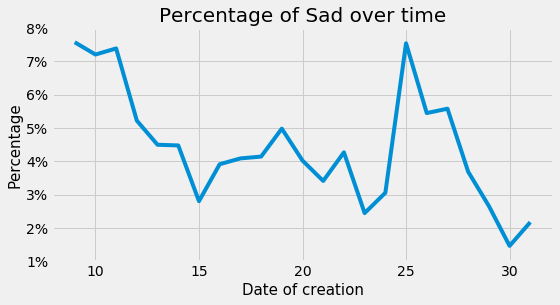

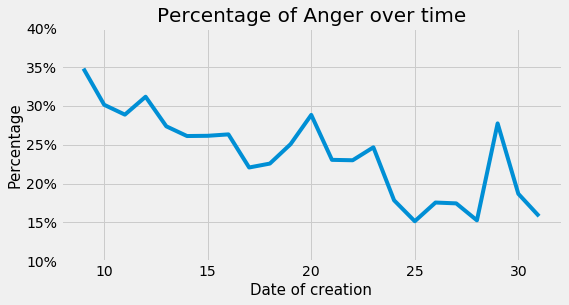

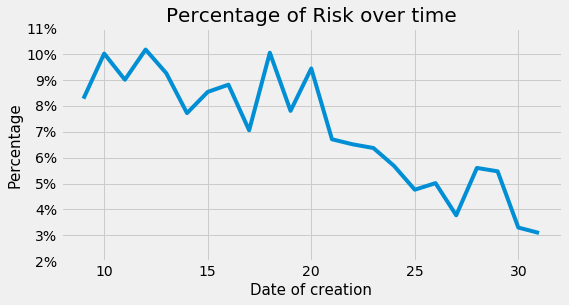

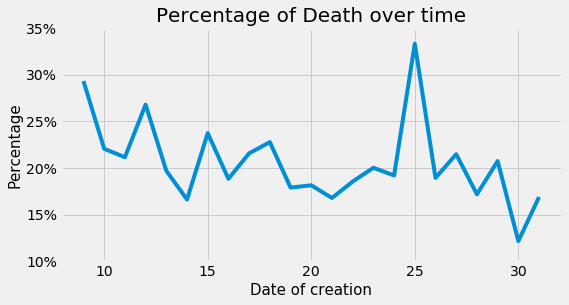

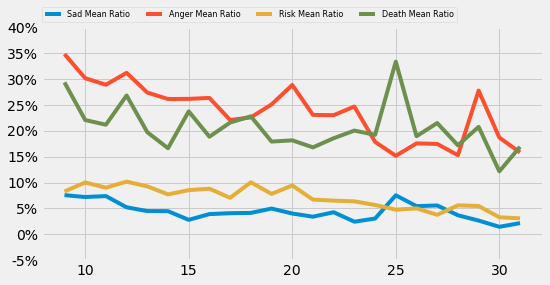

In [31]:
emotion_keys = ['sad', 'anger', 'risk', 'death']

df_emotions = pivot_table_metrics(emotion_keys)

for key in emotion_keys:
    plot_timeline(df_emotions, key)
    
plot_means(df_emotions, emotion_keys)

## Pronouns

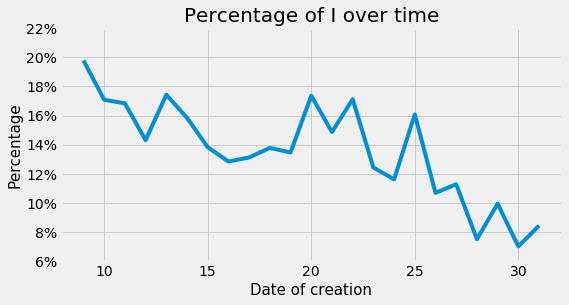

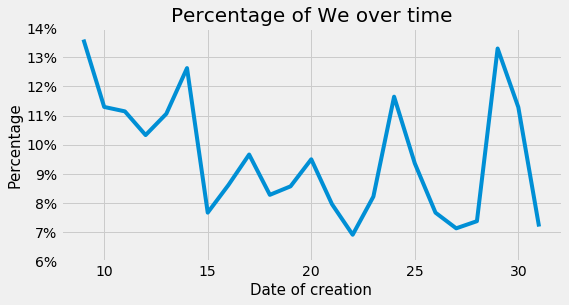

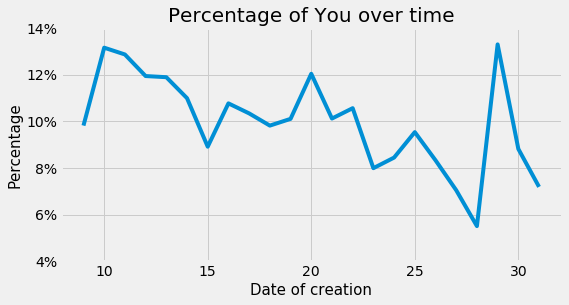

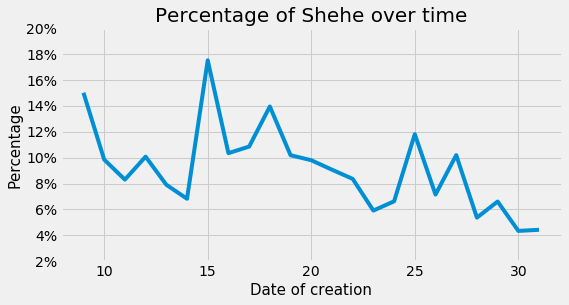

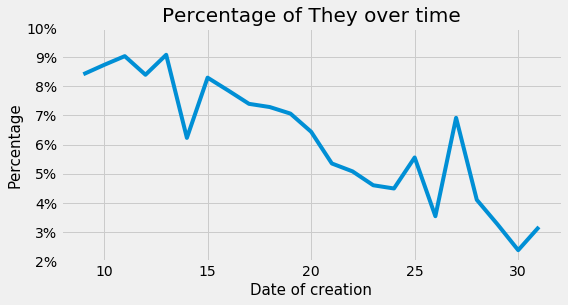

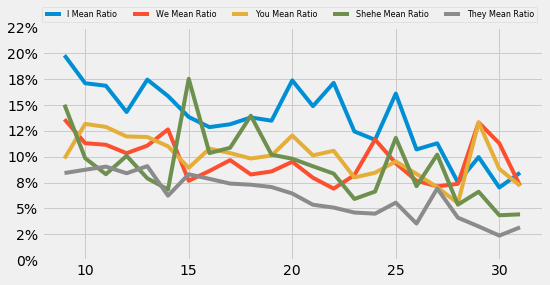

In [32]:
## PRonouns
pronoun_keys = ['i', 'we', 'you', 'shehe', 'they']

df_pronouns = pivot_table_metrics(pronoun_keys)

for key in pronoun_keys:
    plot_timeline(df_pronouns, key)
    
plot_means(df_pronouns, pronoun_keys)

## Social

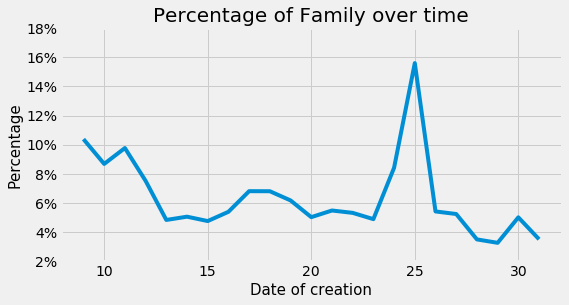

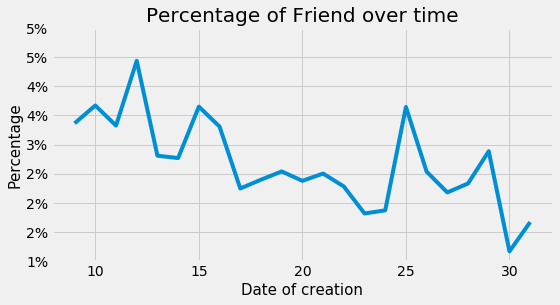

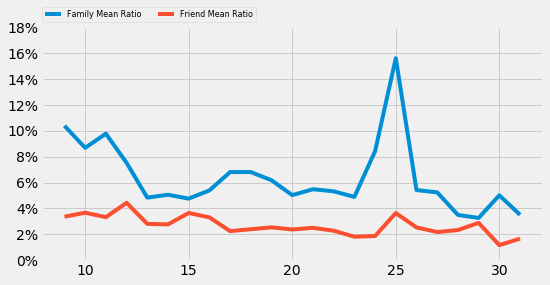

In [33]:
## PRonouns
social_keys = ['family', 'friend']

df_social = pivot_table_metrics(social_keys)

for key in social_keys:
    plot_timeline(df_social, key)
    
plot_means(df_social, social_keys)

## Other

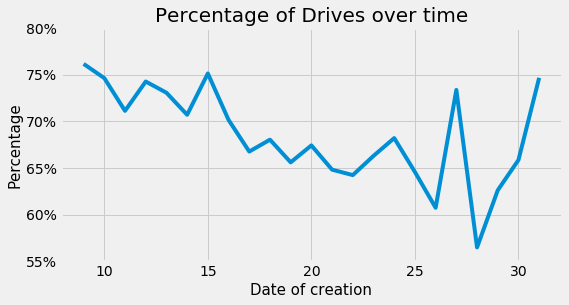

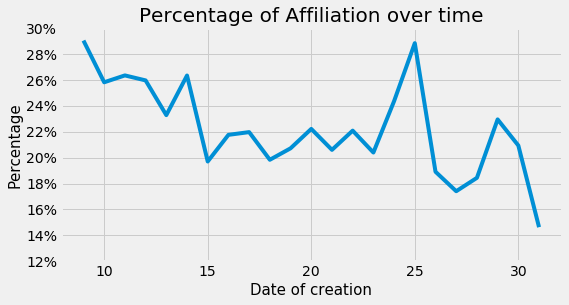

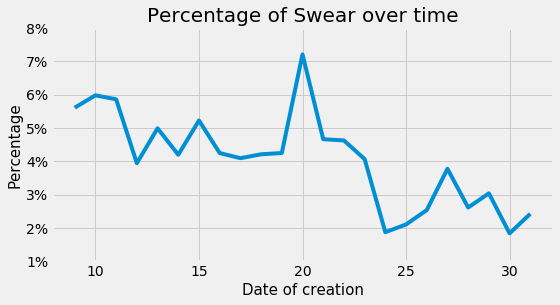

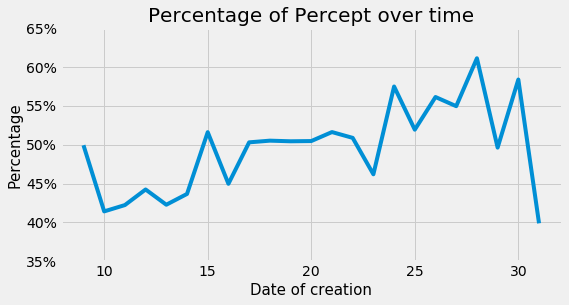

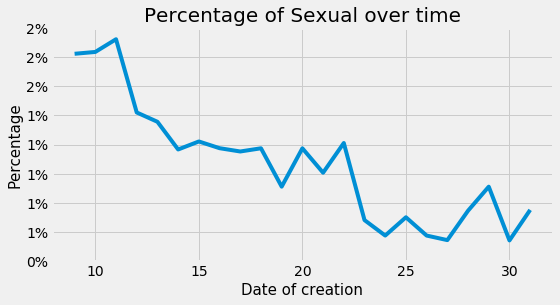

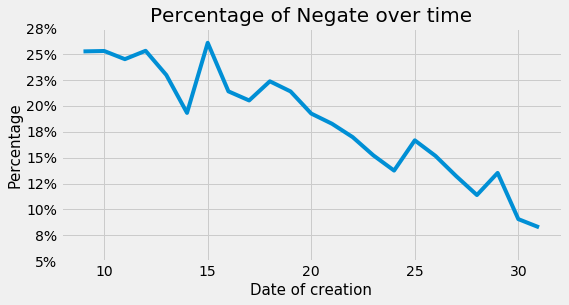

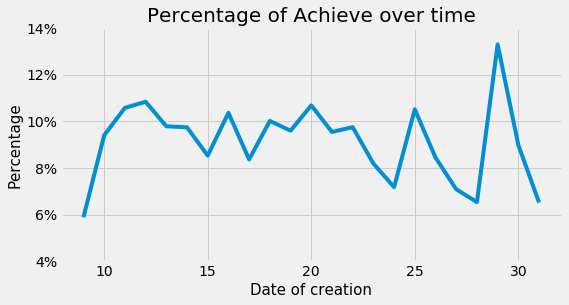

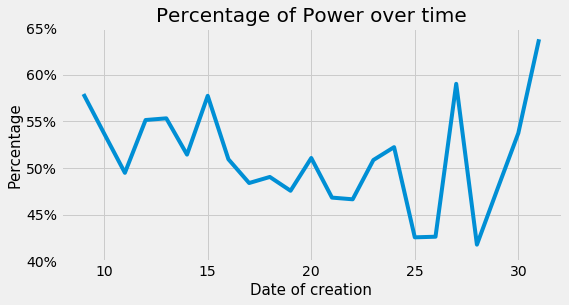

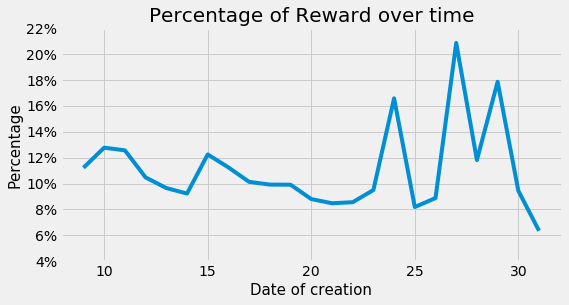

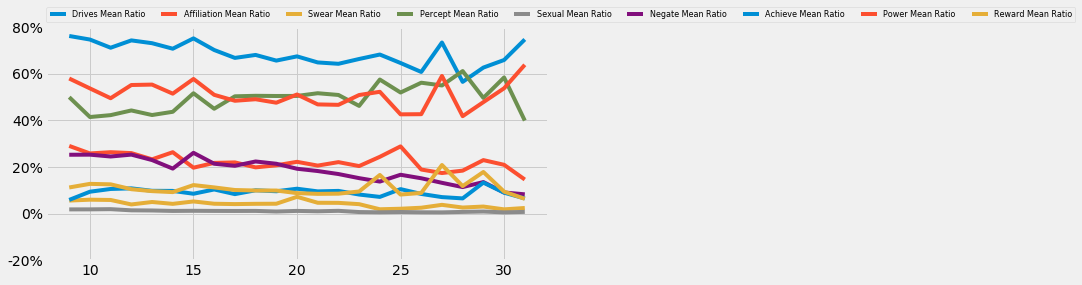

In [34]:
other_keys = ['drives', 'affiliation',
              'swear', 'percept',
              'sexual', 'negate',
        'achieve', 'power', 'reward']

df_other = pivot_table_metrics(other_keys)

for key in other_keys:
    plot_timeline(df_other, key)
    
plot_means(df_other, other_keys)

## LWIC by Topic

In [151]:
## Functions
def pivot_topic_table_metrics(df, topic, keys):
    df_filter = df[df['Dominant_Topic'] == topic]
    d  = {'{}_dummy'.format(x) : [np.mean] for x in keys}
    df_pivot = df_filter.pivot_table(index='day_of_tweet',  aggfunc=d).reset_index()
    df_pivot.columns = ['_'.join(list(x)) for x in df_pivot.columns]
    df_pivot.columns = [x.replace('<lambda>', 'mean') for x in df_pivot.columns]
    return df_pivot

def plot_topic_timelines(df, keys, topics):
    fig, ax = plt.subplots(6, 2, figsize=(10,15), sharex=True, sharey=True,
                          gridspec_kw={'hspace': 0.2, 'wspace': 0})
    axs = ax.ravel()
    
    for i,t in enumerate(topics):
        df_aux = pivot_topic_table_metrics(df, t, keys)
        for key in keys:
            # Visualize the result
            axs[i].plot(df_aux['day_of_tweet_'], 
                    df_aux['{}_dummy_mean'.format(key)], '-', lw=2,
                       label=key)
            axs[i].set_title('Topic: {}'.format(t), size=10)
    
    for axi in axs:
        vals = axi.get_yticks()
        plt.yticks(vals, ['{:,.0%}'.format(x) for x in vals])
        axi.tick_params(axis='both', which='major', labelsize=8)
    plt.legend(bbox_to_anchor=(1.05, 5), loc=2, borderaxespad=0.)
    


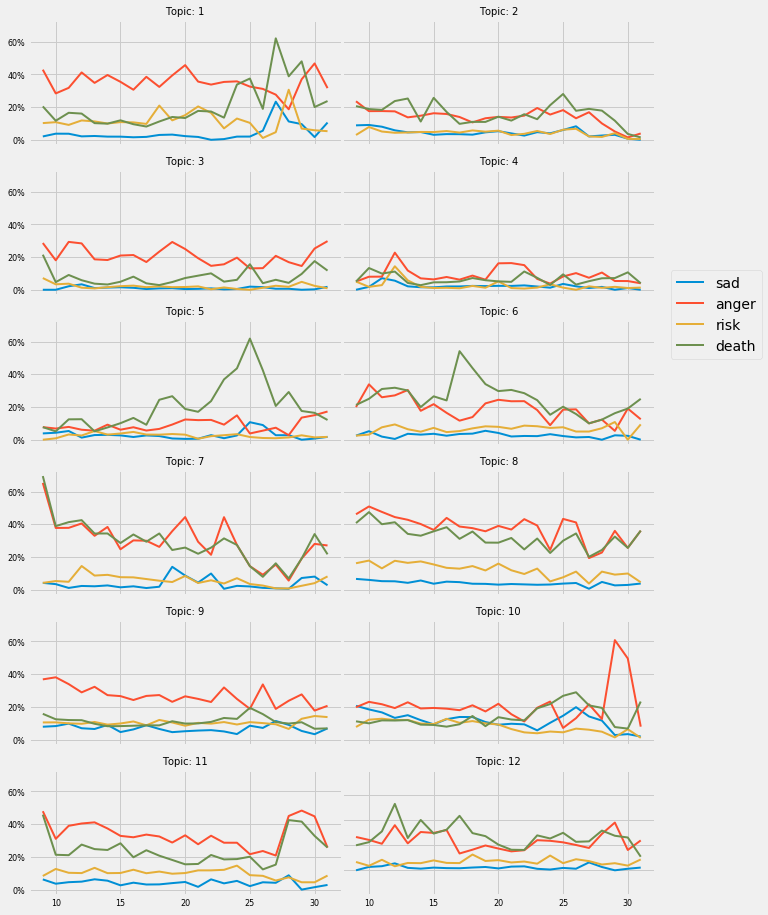

In [154]:
topics = sorted(tweets['Dominant_Topic'].value_counts().index)

emotion_keys = ['sad', 'anger', 'risk', 'death']
plot_topic_timelines(tweets, emotion_keys, topics)

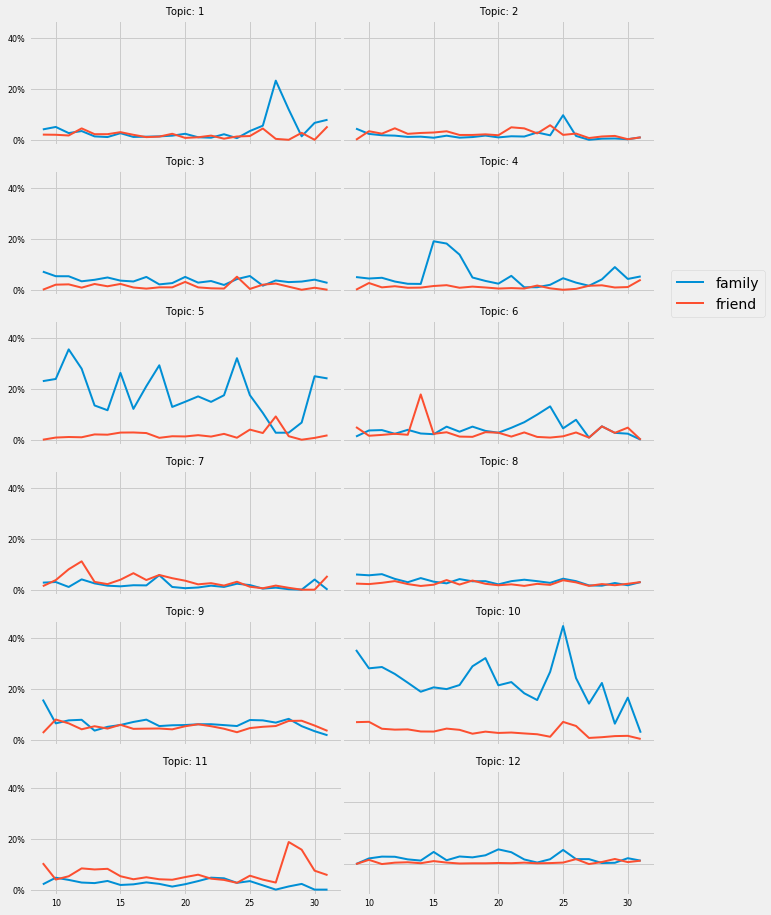

In [155]:
social_keys = ['family', 'friend']
plot_topic_timelines(tweets, social_keys, topics)

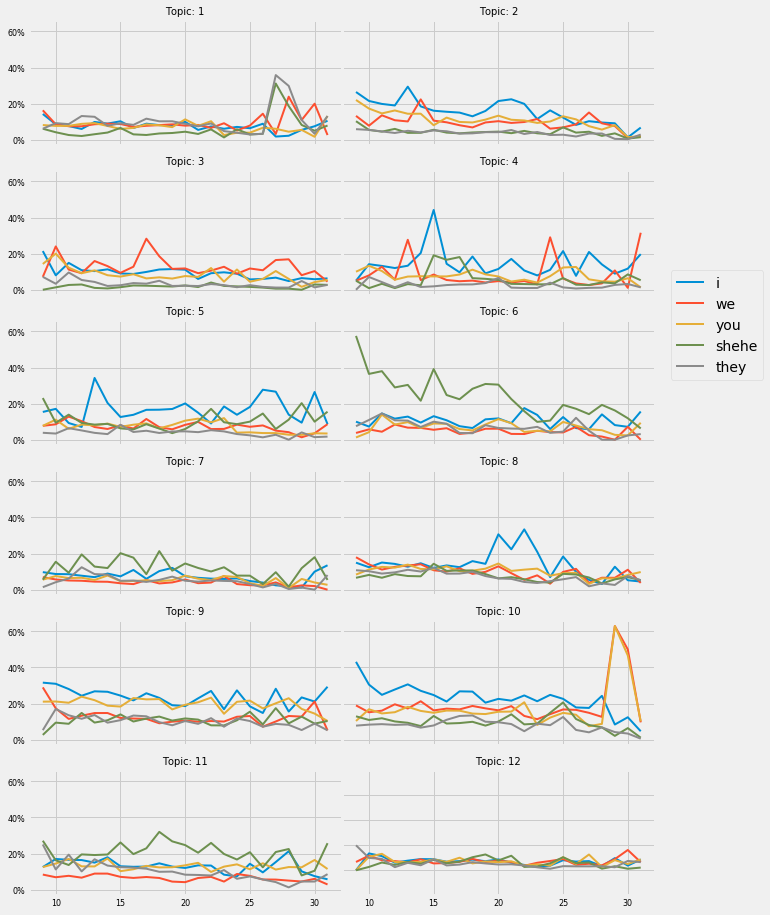

In [156]:
pronoun_keys = ['i', 'we', 'you', 'shehe', 'they']
plot_topic_timelines(tweets, pronoun_keys, topics)

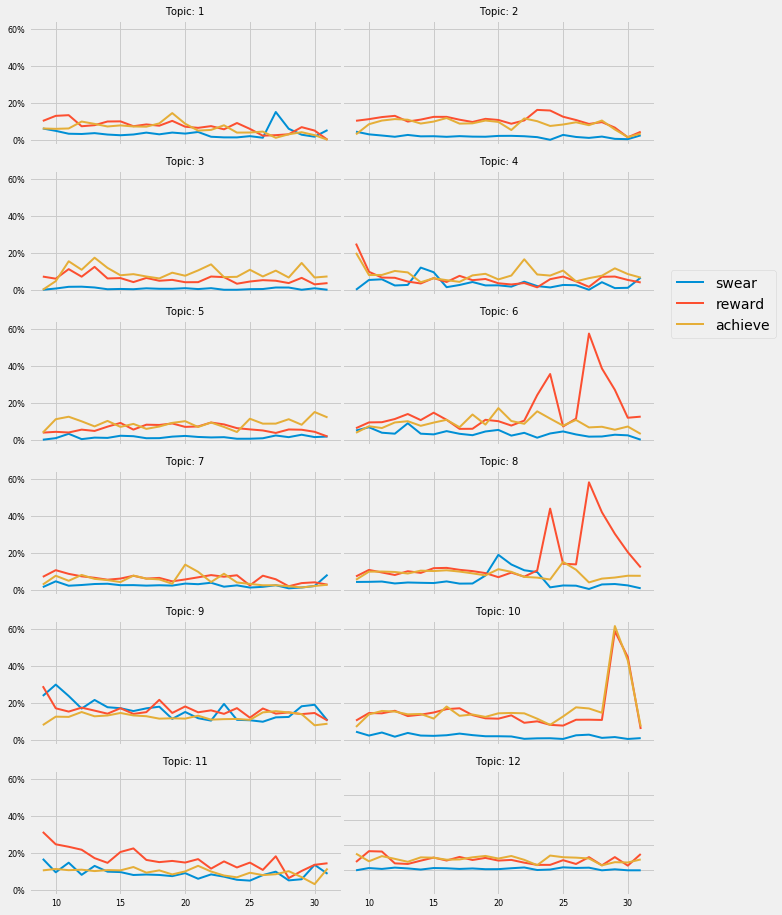

In [170]:
other_keys1= ['swear', 'reward', 'achieve']
plot_topic_timelines(tweets, other_keys1, topics)

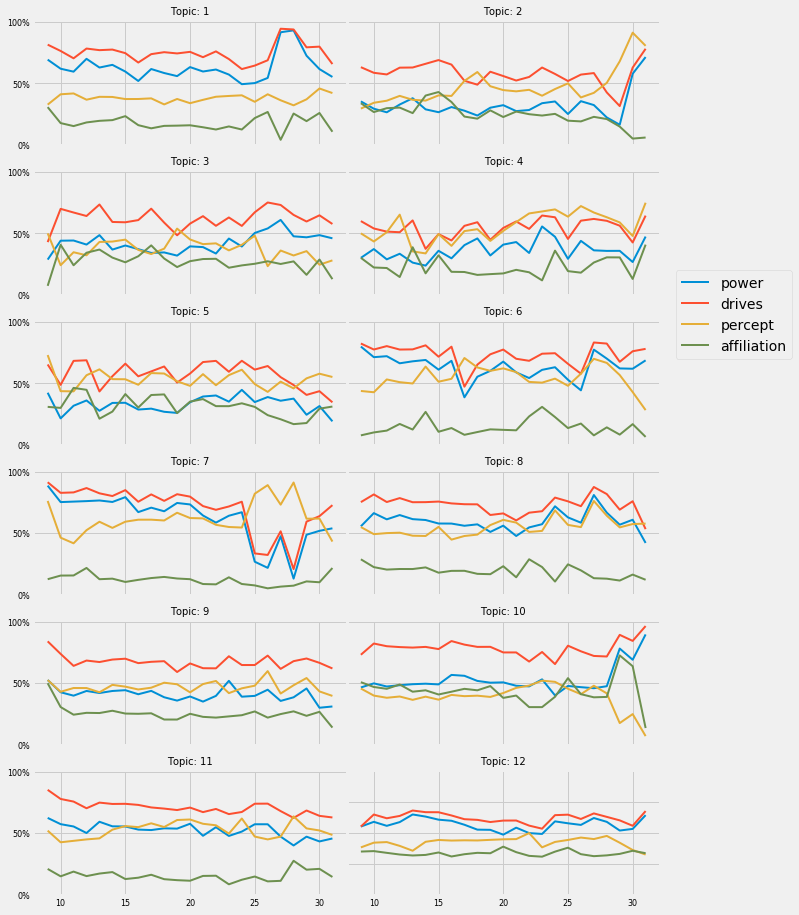

In [171]:
other_keys2= ['power', 'drives', 'percept', 'affiliation']
plot_topic_timelines(tweets, other_keys2, topics)